# Auto Evaluation for Model Comparison

In [14]:
%load_ext autoreload
%autoreload 2

from datasets import load_dataset
import pandas as pd
import yaml
import nest_asyncio
nest_asyncio.apply()

from langchain_mistralai import ChatMistralAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

from utils import *

import warnings
warnings.filterwarnings('ignore')


with open('prompt_versions.yaml', 'r') as file:
    prompt_versions = yaml.safe_load(file)


answer_gen_llm_model_str = 'pixtral-12b-2409'
eval_llm_model_str = 'gpt-5-nano'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data & Generate New Answers

In [2]:
# load raw data
fiqa_eval = load_dataset("explodinggradients/fiqa", "ragas_eval")['baseline']

rag_lst = []
for record in fiqa_eval:
    rag_lst.append({
        'query': record['question'],
        'retrieved_content': record['contexts'],
        'referenced_answer': record['ground_truths'][0],
        'answer1': record['answer'].strip()
    })

rag_df = pd.DataFrame(rag_lst)
print(rag_df.shape)
rag_df.head()

(30, 4)


,query,retrieved_content,referenced_answer,answer1
0,How to deposit a cheque issued to an associate...,[Just have the associate sign the back and the...,Have the check reissued to the proper payee.Ju...,The best way to deposit a cheque issued to an ...
1,Can I send a money order from USPS as a business?,[Sure you can. You can fill in whatever you w...,Sure you can. You can fill in whatever you wa...,"Yes, you can send a money order from USPS as a..."
2,1 EIN doing business under multiple business n...,[You're confusing a lot of things here. Compan...,You're confusing a lot of things here. Company...,"Yes, it is possible to have one EIN doing busi..."
3,Applying for and receiving business credit,[Set up a meeting with the bank that handles y...,"""I'm afraid the great myth of limited liabilit...",Applying for and receiving business credit can...
4,401k Transfer After Business Closure,[The time horizon for your 401K/IRA is essenti...,You should probably consult an attorney. Howev...,If your employer has closed and you need to tr...


In [5]:
# generate new answers using a different LLM
llm = ChatMistralAI(model=answer_gen_llm_model_str, temperature=0)
prompt = PromptTemplate(
    input_variables=["query", "retrieved_content"],
    template="""
    Given the following query and retrieved content, generate a concise and accurate answer:
    
    Query: {query}
    Retrieved Content: {retrieved_content}
    
    Answer:
    """
)
chain = LLMChain(llm=llm, prompt=prompt)

def generate_answer(row):
    return chain.run(query=row['query'], retrieved_content=row['retrieved_content'])

rag_df['answer2'] = rag_df.apply(generate_answer, axis=1)

print(rag_df.shape)
rag_df.head()

(30, 5)


,query,retrieved_content,referenced_answer,answer1,answer2
0,How to deposit a cheque issued to an associate...,[Just have the associate sign the back and the...,Have the check reissued to the proper payee.Ju...,The best way to deposit a cheque issued to an ...,To deposit a cheque issued to an associate in ...
1,Can I send a money order from USPS as a business?,[Sure you can. You can fill in whatever you w...,Sure you can. You can fill in whatever you wa...,"Yes, you can send a money order from USPS as a...","Yes, you can send a money order from USPS as a..."
2,1 EIN doing business under multiple business n...,[You're confusing a lot of things here. Compan...,You're confusing a lot of things here. Company...,"Yes, it is possible to have one EIN doing busi...",To operate a single EIN (Employer Identificati...
3,Applying for and receiving business credit,[Set up a meeting with the bank that handles y...,"""I'm afraid the great myth of limited liabilit...",Applying for and receiving business credit can...,"To apply for and receive business credit, foll..."
4,401k Transfer After Business Closure,[The time horizon for your 401K/IRA is essenti...,You should probably consult an attorney. Howev...,If your employer has closed and you need to tr...,When transferring a 401k after your business c...


### Model Comparison

* Compare the performance of `answer1` and `answer2` to compare the 2 models generated these 2 sets of answers

In [7]:
df1 = rag_df[['query', 'referenced_answer', 'answer1']].rename(columns={'answer1': 'answer'})
df2 = rag_df[['query', 'referenced_answer', 'answer2']].rename(columns={'answer2': 'answer'})

au_df1 = asyncio.run(get_answer_usefulness_output_async(df1, eval_llm_model_str,
                                                        prompt_versions['au_prompt_template'],
                                                        model='openai'))
au_df2 = asyncio.run(get_answer_usefulness_output_async(df2, eval_llm_model_str,
                                                        prompt_versions['au_prompt_template'],
                                                        model='openai'))

print(au_df1.shape, au_df2.shape)
au_df1.head()

(30, 5) (30, 5)


,query,referenced_answer,answer,answer_usefulness_score,au_reasoning
0,How to deposit a cheque issued to an associate...,Have the check reissued to the proper payee.Ju...,The best way to deposit a cheque issued to an ...,0.2,The AI's ANSWER is largely unhelpful and inacc...
1,Can I send a money order from USPS as a business?,Sure you can. You can fill in whatever you wa...,"Yes, you can send a money order from USPS as a...",0.6,The AI's answer is accurate and relevant: it c...
2,1 EIN doing business under multiple business n...,You're confusing a lot of things here. Company...,"Yes, it is possible to have one EIN doing busi...",0.6,The AI's ANSWER correctly states that an EIN c...
3,Applying for and receiving business credit,"""I'm afraid the great myth of limited liabilit...",Applying for and receiving business credit can...,0.6,The ANSWER provides a decent overview of ways ...
4,401k Transfer After Business Closure,You should probably consult an attorney. Howev...,If your employer has closed and you need to tr...,0.4,"The answer is somewhat helpful, correctly noti..."


In [8]:
au_df = au_df1[['query', 'answer_usefulness_score']].merge(
    au_df2[['query', 'answer_usefulness_score']], on='query', suffixes=('_answer1', '_answer2'))
print(au_df.shape)
au_df.head()

(30, 3)


,query,answer_usefulness_score_answer1,answer_usefulness_score_answer2
0,How to deposit a cheque issued to an associate...,0.2,0.6
1,Can I send a money order from USPS as a business?,0.6,0.8
2,1 EIN doing business under multiple business n...,0.6,0.2
3,Applying for and receiving business credit,0.6,0.6
4,401k Transfer After Business Closure,0.4,0.4


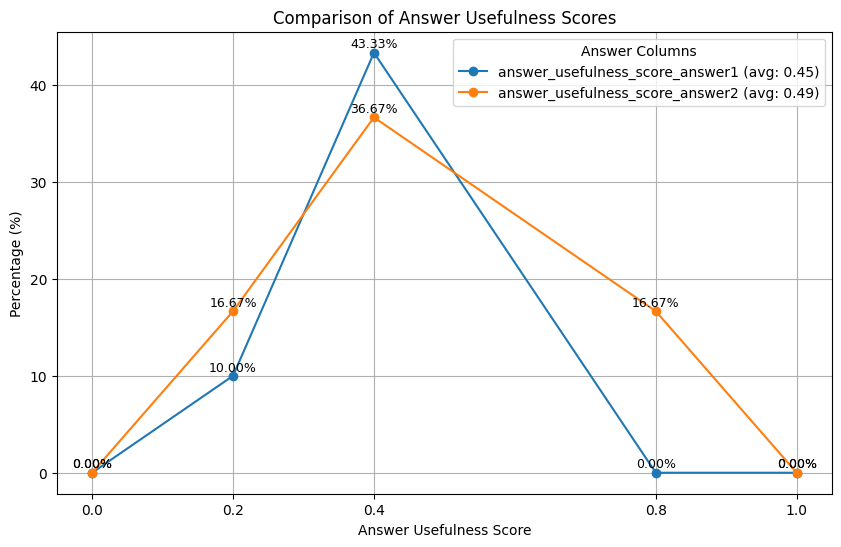

In [ ]:
plot_answer_usefulness_scores(au_df, 
                              ['answer_usefulness_score_answer1', 'answer_usefulness_score_answer2'])